In [1]:
import pandas as pd
import seaborn as sns

In [323]:
def load_sacct(fpath='sacct.log'):
    df = pd.read_csv(fpath, sep=' +', nrows=0)
    df1 = pd.read_csv(fpath, sep=' +', skiprows=3, header=None)
    df['SubmitLine'] = df1.loc[:,4:].apply(lambda r: None if all(e is None for e in r) else ' '.join((
        e for e in r if e is not None)), axis=1)
    df.iloc[:,:4] = df1.iloc[:,:4]  
    df.loc[df.Start=="None", 'Start'] = None
    df.loc[df.Start=="Unknown", 'Start'] = None
    df.loc[df.End=="Unknown", 'End'] = None

    df.TotalCPU = df.TotalCPU.apply(lambda s: (s.replace('-', ' days ') if '-' in s else s).replace('+','00'))
    df.TotalCPU = df.TotalCPU.str.split('\.').str[0]
    df.TotalCPU = df.TotalCPU.apply(lambda s: '00:'+s if len(s.split(':'))<3 else s )
    df['TotalCPU'] = pd.to_timedelta(df['TotalCPU'])
    for c in ('Submit', 'Start', 'End'):
        df[c] = pd.to_datetime(df[c])


    df['proc_time'] = (df.End - df.Start).dt.total_seconds()
    df['total_time'] = (df.End - df.Submit).dt.total_seconds()
    return df

In [324]:
df = load_sacct()
df.head()

/tmp/ipykernel_139693/4180458041.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(fpath, sep=' +', nrows=0)
/tmp/ipykernel_139693/4180458041.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df1 = pd.read_csv(fpath, sep=' +', skiprows=3, header=None)


,Submit,Start,End,TotalCPU,SubmitLine,proc_time,total_time
0,2024-05-18 14:54:25,NaT,2024-05-18 15:28:52,0 days,srun --quiet --nodes=1 --cpus-per-task=128 --account=project_465000498 --partition=standard --time=0-07:00:00 stage2local.sh /scratch/project_465000498/two/html_staging//archivebot_partial/136/html.zst /scratch/project_465000498/two/html_staging//archivebot_partial/136 250,NaN,2067.0
1,2024-05-18 14:54:25,NaT,2024-05-18 15:28:52,0 days,srun --quiet --nodes=1 --cpus-per-task=128 --account=project_465000498 --partition=standard --time=0-07:00:00 stage2local.sh /scratch/project_465000498/two/html_staging//archivebot_partial/134/html.zst /scratch/project_465000498/two/html_staging//archivebot_partial/134 250,NaN,2067.0
2,2024-05-18 14:54:25,NaT,2024-05-18 15:28:52,0 days,srun --quiet --nodes=1 --cpus-per-task=128 --account=project_465000498 --partition=standard --time=0-07:00:00 stage2local.sh /scratch/project_465000498/two/html_staging//archivebot_partial/137/html.zst /scratch/project_465000498/two/html_staging//archivebot_partial/137 250,NaN,2067.0
3,2024-05-18 14:54:25,NaT,2024-05-18 15:28:52,0 days,srun --quiet --nodes=1 --cpus-per-task=128 --account=project_465000498 --partition=standard --time=0-07:00:00 stage2local.sh /scratch/project_465000498/two/html_staging//archivebot_partial/14/html.zst /scratch/project_465000498/two/html_staging//archivebot_partial/14 250,NaN,2067.0
4,2024-05-18 14:54:25,NaT,2024-05-18 15:28:52,0 days,srun --quiet --nodes=1 --cpus-per-task=128 --account=project_465000498 --partition=standard --time=0-07:00:00 stage2local.sh /scratch/project_465000498/two/html_staging//archivebot_partial/132/html.zst /scratch/project_465000498/two/html_staging//archivebot_partial/132 250,NaN,2067.0


In [327]:
print(df.proc_time.sum() / 3600,'hours processing time')

print(df.total_time.sum() / 3600,'hours waiting+processing time')
print(df.TotalCPU.sum() / 3600, 'CPU-hours')

3165.358333333333 hours processing time
18597.3825 hours waiting+processing time
4 days 10:05:45.981666666 CPU-hours


In [57]:
df.proc_time.describe()

count     1888.000000
mean      6035.640890
std       4379.244614
min          3.000000
25%       1072.750000
50%       5402.500000
75%      10971.500000
max      17896.000000
Name: proc_time, dtype: float64

In [58]:
df.total_time.describe()

count      1912.000000
mean      35015.992155
std       40973.634790
min           3.000000
25%        5287.000000
50%       12560.500000
75%       48444.750000
max      167882.000000
Name: total_time, dtype: float64

In [59]:
df.SubmitLine.iloc[2]

'srun --quiet --nodes=1 --cpus-per-task=128 --account=project_465000498 --partition=standard --time=0-07:00:00 stage2local.sh /scratch/project_465000498/two/html_staging//archivebot_partial/137/html.zst /scratch/project_465000498/two/html_staging//archivebot_partial/137 250'

In [60]:
df['path'] = df.SubmitLine.str.extract('stage2local.sh .*/([^/]+/[^/]+/html.zst) ')

In [61]:
df = df.dropna()
df

,Submit,Start,End,TotalCPU,SubmitLine,proc_time,total_time,path
24,2024-05-18 16:51:14,2024-05-18 17:06:17,2024-05-18 17:18:10,22:24:12,srun --quiet --nodes=1 --cpus-per-task=128 --a...,713.0,1616.0,archivebot_partial/1/html.zst
25,2024-05-18 17:06:18,2024-05-18 17:06:18,2024-05-18 17:18:10,22:24:12,srun --quiet --nodes=1 --cpus-per-task=128 --a...,712.0,712.0,archivebot_partial/1/html.zst
26,2024-05-18 17:08:14,2024-05-18 17:22:32,2024-05-18 17:37:10,1-01:58:38,srun --quiet --nodes=1 --cpus-per-task=128 --a...,878.0,1736.0,archivebot_partial/10/html.zst
27,2024-05-18 17:22:33,2024-05-18 17:22:33,2024-05-18 17:37:10,1-01:58:38,srun --quiet --nodes=1 --cpus-per-task=128 --a...,877.0,877.0,archivebot_partial/10/html.zst
28,2024-05-18 20:28:14,2024-05-18 23:43:08,2024-05-19 00:44:45,5-09:22:02,srun --quiet --nodes=1 --cpus-per-task=128 --a...,3697.0,15391.0,CC-MAIN-2017-04/67/html.zst
...,...,...,...,...,...,...,...,...
1907,2024-05-26 13:45:23,2024-05-26 13:45:23,2024-05-26 14:00:08,1-04:30:50,srun --quiet --nodes=1 --cpus-per-task=128 --a...,885.0,885.0,archivebot_partial/79/html.zst
1908,2024-05-25 21:45:06,2024-05-26 17:18:07,2024-05-26 18:44:22,7-13:22:02,srun --quiet --nodes=1 --cpus-per-task=128 --a...,5175.0,75556.0,wide00012/190/html.zst
1909,2024-05-26 17:18:07,2024-05-26 17:18:07,2024-05-26 18:44:22,7-13:22:02,srun --quiet --nodes=1 --cpus-per-task=128 --a...,5175.0,5175.0,wide00012/190/html.zst
1910,2024-05-25 21:49:51,2024-05-26 17:18:07,2024-05-26 18:48:50,7-19:31:04,srun --quiet --nodes=1 --cpus-per-task=128 --a...,5443.0,75539.0,wide00012/19/html.zst


In [62]:
qdf = pd.concat([pd.read_csv(p, header=None, sep='\t', names=['kb','path']) 
    for p in ('../cesnet/html_sizes.tsv', '../nirdl/html_sizes.tsv')], ignore_index=True)

In [63]:
qdf.path = qdf.path.str.strip('./')

In [64]:
df = df.merge(qdf, on='path', how='left')
df

,Submit,Start,End,TotalCPU,SubmitLine,proc_time,total_time,path,kb
0,2024-05-18 16:51:14,2024-05-18 17:06:17,2024-05-18 17:18:10,22:24:12,srun --quiet --nodes=1 --cpus-per-task=128 --a...,713.0,1616.0,archivebot_partial/1/html.zst,7508336
1,2024-05-18 17:06:18,2024-05-18 17:06:18,2024-05-18 17:18:10,22:24:12,srun --quiet --nodes=1 --cpus-per-task=128 --a...,712.0,712.0,archivebot_partial/1/html.zst,7508336
2,2024-05-18 17:08:14,2024-05-18 17:22:32,2024-05-18 17:37:10,1-01:58:38,srun --quiet --nodes=1 --cpus-per-task=128 --a...,878.0,1736.0,archivebot_partial/10/html.zst,13158544
3,2024-05-18 17:22:33,2024-05-18 17:22:33,2024-05-18 17:37:10,1-01:58:38,srun --quiet --nodes=1 --cpus-per-task=128 --a...,877.0,877.0,archivebot_partial/10/html.zst,13158544
4,2024-05-18 20:28:14,2024-05-18 23:43:08,2024-05-19 00:44:45,5-09:22:02,srun --quiet --nodes=1 --cpus-per-task=128 --a...,3697.0,15391.0,CC-MAIN-2017-04/67/html.zst,123647792
...,...,...,...,...,...,...,...,...,...
1887,2024-05-26 13:45:23,2024-05-26 13:45:23,2024-05-26 14:00:08,1-04:30:50,srun --quiet --nodes=1 --cpus-per-task=128 --a...,885.0,885.0,archivebot_partial/79/html.zst,7810272
1888,2024-05-25 21:45:06,2024-05-26 17:18:07,2024-05-26 18:44:22,7-13:22:02,srun --quiet --nodes=1 --cpus-per-task=128 --a...,5175.0,75556.0,wide00012/190/html.zst,195581404
1889,2024-05-26 17:18:07,2024-05-26 17:18:07,2024-05-26 18:44:22,7-13:22:02,srun --quiet --nodes=1 --cpus-per-task=128 --a...,5175.0,5175.0,wide00012/190/html.zst,195581404
1890,2024-05-25 21:49:51,2024-05-26 17:18:07,2024-05-26 18:48:50,7-19:31:04,srun --quiet --nodes=1 --cpus-per-task=128 --a...,5443.0,75539.0,wide00012/19/html.zst,197797612


In [65]:
(df.kb / 2**20).describe()

count    1892.000000
mean      221.319712
std       194.843260
min         0.774261
25%        32.275061
50%       181.362691
75%       365.300339
max       674.669037
Name: kb, dtype: float64

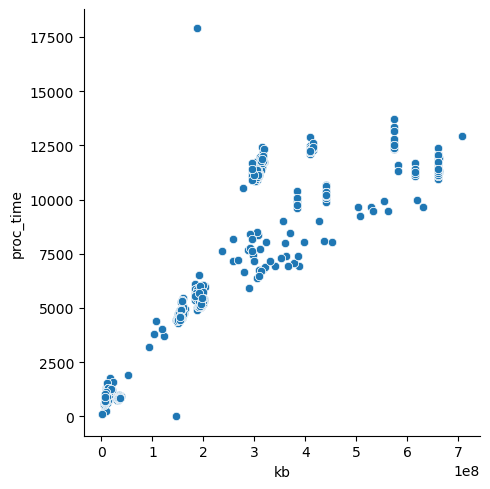

In [66]:
sns.relplot(data=df, y='proc_time', x='kb', kind='scatter')

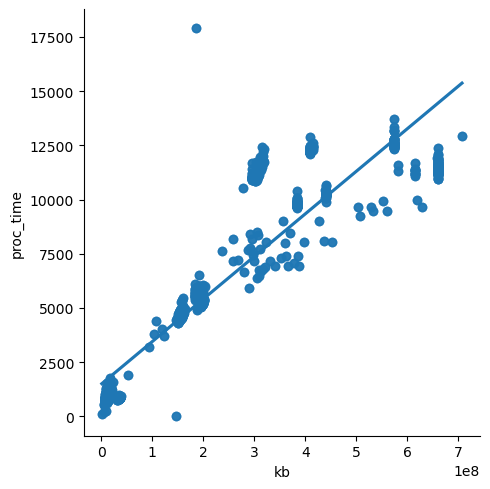

In [67]:
sns.lmplot(data=df, x='kb', y='proc_time', order=1, ci=0.95)

<Axes: xlabel='kb'>

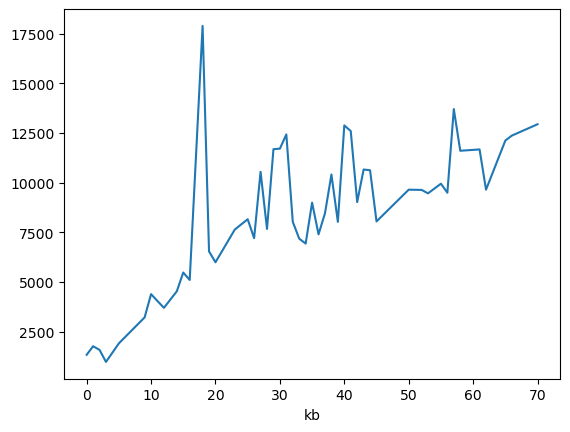

In [68]:
df.groupby(df.kb // 10**7).proc_time.max().plot()

In [69]:
df.proc_time.max() /3600

4.971111111111111

In [70]:
df.proc_time.describe(percentiles=[.999]) / 3600

count    0.525556
mean     1.679412
std      1.216816
min      0.000833
50%      1.502778
99.9%    3.934581
max      4.971111
Name: proc_time, dtype: float64

In [71]:
df.kb.max()//2**20

674

# Analyze all running time for all data, round2, stage2

In [328]:
fpath = '../qualitycontrol/sacct_stage2_all.log'
df=load_sacct(fpath)

/tmp/ipykernel_139693/4180458041.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(fpath, sep=' +', nrows=0)
/tmp/ipykernel_139693/4180458041.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df1 = pd.read_csv(fpath, sep=' +', skiprows=3, header=None)


In [347]:
print(df.proc_time.sum() / 3600,'hours processing time')

print(df.total_time.sum() / 3600,'hours waiting+processing time')
print(df.TotalCPU.sum(), 'CPU-hours')

14913.748333333333 hours processing time
47191.91861111111 hours waiting+processing time
73986 days 22:20:08.999999488 CPU-hours


In [366]:
print(df.TotalCPU.sum().total_seconds() / 3600 / 10**6, 'million cpu-hours')

1.7685384924999996 million cpu-hours


In [367]:
df['script'] = df.SubmitLine.str.extract('(stage2.*sh)')
df = df.dropna()

/tmp/ipykernel_139693/3101487074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['script'] = df.SubmitLine.str.extract('(stage2.*sh)')


In [368]:
df.groupby('script').TotalCPU.sum()

script
stage2local.sh             46880 days 10:23:41
stage2local_batch.sh       26693 days 16:04:06
stage2local_procratio.sh     115 days 00:01:46
Name: TotalCPU, dtype: timedelta64[ns]